In [1]:
library("tidyverse")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [2]:
library("DT")

In [3]:
cases <- read_csv("COVID-19_cases_plus_census.csv")

Parsed with column specification:
cols(
  .default = col_double(),
  county_fips_code = col_character(),
  county_name = col_character(),
  state = col_character(),
  state_fips_code = col_character(),
  date = col_date(format = ""),
  geo_id = col_character(),
  pop_5_years_over = col_logical(),
  speak_only_english_at_home = col_logical(),
  speak_spanish_at_home = col_logical(),
  speak_spanish_at_home_low_english = col_logical(),
  pop_15_and_over = col_logical(),
  pop_never_married = col_logical(),
  pop_now_married = col_logical(),
  pop_separated = col_logical(),
  pop_widowed = col_logical(),
  pop_divorced = col_logical()
)
See spec(...) for full column specifications.


In [4]:
cases <- cases %>% mutate_if(is.character, factor)
dim(cases)

[1] 3142  259

In [5]:
cases <- cases %>% filter(confirmed_cases > 0) 

cases <- cases %>% 
  arrange(desc(confirmed_cases)) #%>%    
  #select(county_name, state, confirmed_cases, deaths, total_pop, median_income, median_age)
cases <- cases %>% mutate(
  cases_per_1000 = confirmed_cases/total_pop*1000, 
  deaths_per_1000 = deaths/total_pop*1000, 
  death_per_case = deaths/confirmed_cases)

cases

county_fips_code,county_name,state,state_fips_code,date,confirmed_cases,deaths,geo_id,nonfamily_households,family_households,...,pop_15_and_over,pop_never_married,pop_now_married,pop_separated,pop_widowed,pop_divorced,do_date,cases_per_1000,deaths_per_1000,death_per_case
06037,Los Angeles County,CA,06,2021-01-19,1002614,13936,06037,1091276,2203922,...,NA,NA,NA,NA,NA,NA,20132017,99.21251,1.3790207,0.013899666
17031,Cook County,IL,17,2021-01-19,435888,8544,17031,773610,1182951,...,NA,NA,NA,NA,NA,NA,20132017,83.20790,1.6309885,0.019601365
04013,Maricopa County,AZ,04,2021-01-19,425844,6443,04013,513279,976254,...,NA,NA,NA,NA,NA,NA,20132017,102.47717,1.5504749,0.015129954
12086,Miami-Dade County,FL,12,2021-01-19,347965,4622,12086,272813,585476,...,NA,NA,NA,NA,NA,NA,20132017,128.75185,1.7102037,0.013282945
48201,Harris County,TX,48,2021-01-19,286356,3825,48201,496164,1066649,...,NA,NA,NA,NA,NA,NA,20132017,63.27584,0.8452069,0.013357499
06071,San Bernardino County,CA,06,2021-01-19,252808,1560,06071,149939,473703,...,NA,NA,NA,NA,NA,NA,20132017,119.18047,0.7354258,0.006170691
06065,Riverside County,CA,06,2021-01-19,244151,2517,06065,189392,522332,...,NA,NA,NA,NA,NA,NA,20132017,103.67337,1.0687889,0.010309194
48113,Dallas County,TX,48,2021-01-19,234625,2453,48113,315704,590475,...,NA,NA,NA,NA,NA,NA,20132017,91.93002,0.9611267,0.010454981
06073,San Diego County,CA,06,2021-01-19,214335,2103,06073,364494,747245,...,NA,NA,NA,NA,NA,NA,20132017,65.27310,0.6404429,0.009811743
06059,Orange County,CA,06,2021-01-19,213866,2367,06059,285924,739052,...,NA,NA,NA,NA,NA,NA,20132017,67.76884,0.7500437,0.011067678


In [6]:
cases_sel <- cases %>% select(county_name, state, cases_per_1000, deaths_per_1000, 
    death_per_case, total_pop, white_pop, black_pop, asian_pop, hispanic_pop, 
    amerindian_pop, median_age, male_pop, female_pop, median_income,
    income_per_capita, median_rent, poverty, commuters_by_public_transportation, percent_income_spent_on_rent, 
    income_less_10000, income_10000_14999, income_15000_19999, income_20000_24999,
    income_25000_29999, income_30000_34999, income_35000_39999,income_40000_44999,
    income_45000_49999, income_50000_59999, income_60000_74999, income_75000_99999,
    income_100000_124999, income_125000_149999, income_150000_199999, income_200000_or_more)

# normalize by population 
cases_sel <- cases_sel %>% mutate(
    white_pop = white_pop / total_pop, 
    black_pop = black_pop / total_pop, 
    asian_pop = asian_pop / total_pop, 
    hispanic_pop = hispanic_pop / total_pop, 
    amerindian_pop = amerindian_pop / total_pop,
    male_pop = male_pop / total_pop,
    female_pop = female_pop / total_pop,
    commuters_by_public_transportation = commuters_by_public_transportation/ total_pop,
    income_less_10000 = income_less_10000/total_pop, 
    income_10000_14999 = income_10000_14999/total_pop,
    income_15000_19999 = income_15000_19999/total_pop,
    income_20000_24999 = income_20000_24999/total_pop,
    income_25000_29999 = income_25000_29999/total_pop, 
    income_30000_34999 = income_30000_34999/total_pop, 
    income_35000_39999 = income_35000_39999/total_pop,
    income_40000_44999 = income_40000_44999/total_pop,
    income_45000_49999 = income_45000_49999/total_pop,
    income_50000_59999 = income_50000_59999/total_pop,
    income_60000_74999 = income_60000_74999/total_pop,
    income_75000_99999 = income_75000_99999/total_pop,
    income_100000_124999 = income_100000_124999/total_pop,
    income_125000_149999 = income_125000_149999/total_pop,
    income_150000_199999 = income_150000_199999/total_pop,
    income_200000_or_more = income_200000_or_more/total_pop)

cases_sel

county_name,state,cases_per_1000,deaths_per_1000,death_per_case,total_pop,white_pop,black_pop,asian_pop,hispanic_pop,...,income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more
Los Angeles County,CA,99.21251,1.3790207,0.013899666,10105722,0.26489765,0.07912141,0.14274853,0.48423843,...,0.013453170,0.013746371,0.011926807,0.02310938,0.03031461,0.03834481,0.02847743,0.01876343,0.022173379,0.027443363
Cook County,IL,83.20790,1.6309885,0.019601365,5238541,0.42675966,0.23406021,0.06931014,0.25050945,...,0.015327932,0.015820817,0.013279652,0.02668415,0.03477018,0.04478747,0.03223149,0.02094992,0.024055362,0.028694822
Maricopa County,AZ,102.47717,1.5504749,0.015129954,4155501,0.56313426,0.05083093,0.03860882,0.30603915,...,0.016620860,0.017634937,0.014853323,0.02970232,0.03683022,0.04514570,0.03220189,0.01956972,0.020561660,0.021261215
Miami-Dade County,FL,128.75185,1.7102037,0.013282945,2702602,0.13736133,0.16339957,0.01512172,0.67454919,...,0.015306360,0.015145034,0.013498103,0.02340263,0.02864869,0.03254382,0.02160881,0.01247020,0.013415220,0.017090937
Harris County,TX,63.27584,0.8452069,0.013357499,4525519,0.30639049,0.18523511,0.06786161,0.42216926,...,0.015562193,0.016178476,0.013463207,0.02704441,0.03371260,0.03932831,0.02905015,0.01837071,0.020521845,0.026969724
San Bernardino County,CA,119.18047,0.7354258,0.006170691,2121220,0.29820434,0.07966406,0.06732069,0.52281046,...,0.013010909,0.013846749,0.011797928,0.02390417,0.03128954,0.03778345,0.02716126,0.01566834,0.017257993,0.012149612
Riverside County,CA,103.67337,1.0687889,0.010309194,2355002,0.36571986,0.05979188,0.06108487,0.47984375,...,0.013450519,0.013493407,0.011687464,0.02276304,0.03105985,0.03919445,0.02869976,0.01834266,0.019700620,0.016120581
Dallas County,TX,91.93002,0.9611267,0.010454981,2552213,0.30219186,0.22067907,0.05957379,0.39627335,...,0.017471504,0.018230453,0.015049684,0.02979493,0.03604049,0.04053267,0.02747145,0.01591364,0.017980082,0.022594117
San Diego County,CA,65.27310,0.6404429,0.009811743,3283665,0.46203038,0.04708123,0.11470994,0.33360833,...,0.012889865,0.013572639,0.012009142,0.02451255,0.03252311,0.04358940,0.03449743,0.02300235,0.027648375,0.031637819
Orange County,CA,67.76884,0.7500437,0.011067678,3155816,0.41396520,0.01570434,0.19508710,0.34196290,...,0.010343442,0.010962616,0.010587119,0.02133299,0.02961833,0.04198312,0.03392815,0.02456259,0.031801917,0.042175463


In [7]:
table(complete.cases(cases_sel))


FALSE  TRUE 
    2  3137 

In [8]:
str(cases_sel)

Classes 'spec_tbl_df', 'tbl_df', 'tbl' and 'data.frame':	3139 obs. of  36 variables:
 $ county_name                       : Factor w/ 1878 levels "Abbeville County",..: 1003 399 1043 1106 737 1476 1429 447 1477 1249 ...
 $ state                             : Factor w/ 51 levels "AK","AL","AR",..: 5 15 4 10 44 5 5 44 5 5 ...
 $ cases_per_1000                    : num  99.2 83.2 102.5 128.8 63.3 ...
 $ deaths_per_1000                   : num  1.379 1.631 1.55 1.71 0.845 ...
 $ death_per_case                    : num  0.0139 0.0196 0.0151 0.0133 0.0134 ...
 $ total_pop                         : num  10105722 5238541 4155501 2702602 4525519 ...
 $ white_pop                         : num  0.265 0.427 0.563 0.137 0.306 ...
 $ black_pop                         : num  0.0791 0.2341 0.0508 0.1634 0.1852 ...
 $ asian_pop                         : num  0.1427 0.0693 0.0386 0.0151 0.0679 ...
 $ hispanic_pop                      : num  0.484 0.251 0.306 0.675 0.422 ...
 $ amerindian_pop            

In [9]:
library(seriation)
cm <- cor(cases_sel %>% select_if(is.numeric) %>% na.omit)

Warning message:
"package 'seriation' was built under R version 3.6.3"

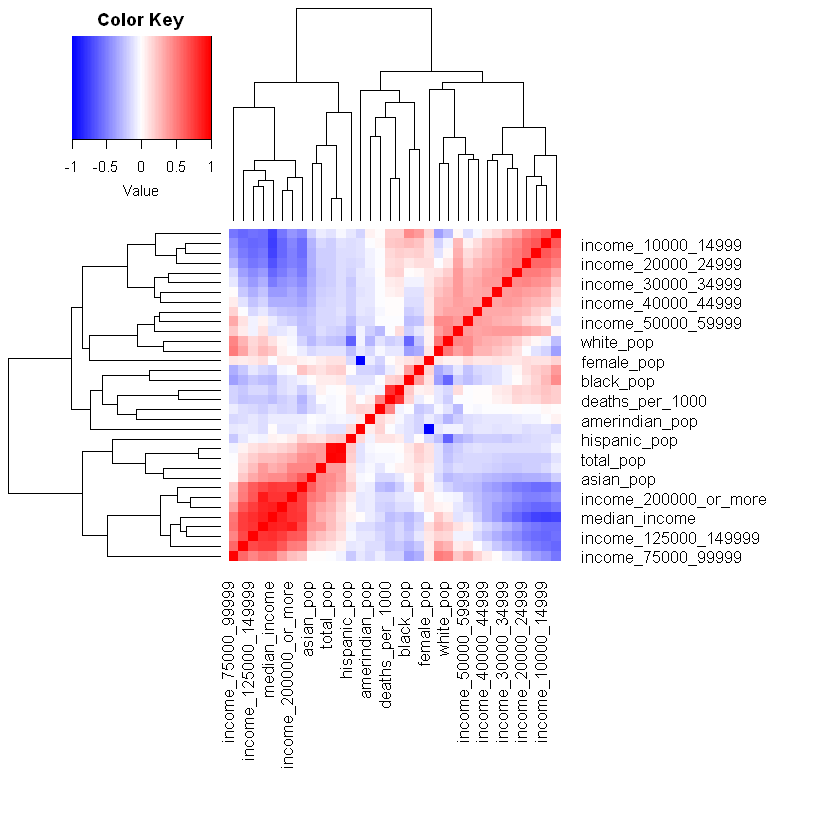

In [10]:
hmap(cm, margins = c(14,14))

In [11]:
summary(cases_sel$deaths_per_1000)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.6822  1.1901  1.3368  1.7520  8.3587 

In [12]:
mean = mean(cases_sel$deaths_per_1000)
cases_sel <- cases_sel %>% mutate(bad = as.factor(deaths_per_1000 > mean))

In [13]:
cases_sel %>% pull(bad) %>% table()

.
FALSE  TRUE 
 1806  1333 

In [14]:
cases_sel %>% group_by(state) %>% 
  summarize(bad_pct = sum(bad == TRUE)/n()) %>%
  arrange(desc(bad_pct))

state,bad_pct
NJ,0.95238095
MS,0.90243902
AZ,0.86666667
LA,0.85937500
MA,0.85714286
SD,0.69696970
ND,0.67924528
IA,0.67676768
AL,0.67164179
TX,0.66535433


In [15]:
cases_train <- cases_sel %>% filter(state %in% c("TX", "CA", "FL", "NY"))
cases_train %>% pull(bad) %>% table()

.
FALSE  TRUE 
  220   221 

In [16]:
cases_test <-  cases_sel %>% filter(!(state %in% c("TX", "CA", "FL", "NY")))
cases_test %>% pull(bad) %>% table()

.
FALSE  TRUE 
 1586  1112 

In [17]:
counties <- as_tibble(map_data("county")) %>%
  rename(county = subregion, state = region) %>%
  mutate(state = state.abb[match(tolower(state), tolower(state.name))]) %>%
  select(state, county, long, lat, group)
counties


Attaching package: 'maps'

The following object is masked from 'package:purrr':

    map



state,county,long,lat,group
AL,autauga,-86.50517,32.34920,1
AL,autauga,-86.53382,32.35493,1
AL,autauga,-86.54527,32.36639,1
AL,autauga,-86.55673,32.37785,1
AL,autauga,-86.57966,32.38357,1
AL,autauga,-86.59111,32.37785,1
AL,autauga,-86.61403,32.38931,1
AL,autauga,-86.61976,32.40649,1
AL,autauga,-86.62549,32.41795,1
AL,autauga,-86.63695,32.41795,1


In [18]:
counties_all <- counties %>% left_join(cases_train %>% 
    mutate(county = county_name %>% str_to_lower() %>% 
        str_replace('\\s+county\\s*$', '')))

Joining, by = c("state", "county")
Warning message:
"Column `state` joining character vector and factor, coercing into character vector"

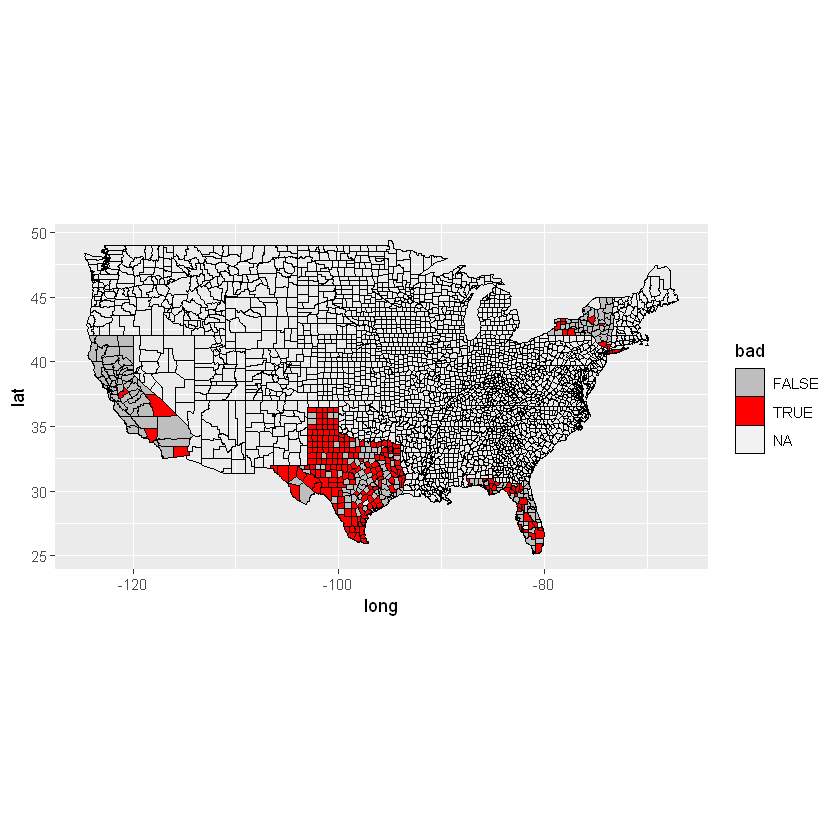

In [19]:
ggplot(counties_all, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = bad), color = "black", size = 0.1) + 
    coord_quickmap() + scale_fill_manual(values = c('TRUE' = 'red', 'FALSE' = 'grey'))

In [20]:
library(FSelector)
cases_train %>%  chi.squared(bad ~ ., data = .) %>% 
  arrange(desc(attr_importance)) %>% head()

Warning message:
"package 'FSelector' was built under R version 3.6.3"

attr_importance
1.0000000
0.9657786
0.7250216
0.4902105
0.4361745
0.4319332


In [21]:
cases_train <- cases_train %>% select(-c(deaths_per_1000))
cases_train %>%  chi.squared(bad ~ ., data = .) %>% 
  arrange(desc(attr_importance)) %>% head()

attr_importance
0.9657786
0.7250216
0.4902105
0.4361745
0.4319332
0.3711630


In [22]:
cases_train <- cases_train %>% select(-death_per_case, -cases_per_1000)

cases_train %>%  chi.squared(bad ~ ., data = .) %>% 
  arrange(desc(attr_importance)) %>% head(n = 10)

attr_importance
0.9657786
0.4902105
0.4361745
0.3711630
0.3650781
0.3529355
0.3524598
0.3361204
0.3338209
0.3239074


In [23]:
library(caret)

Loading required package: lattice

Attaching package: 'lattice'

The following object is masked from 'package:seriation':

    panel.lines


Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift



In [24]:
fit <- cases_train %>%
  train(bad ~ . - county_name - state,
    data = . ,
    #method = "rpart",
    method = "rf",
    #method = "nb",
    trControl = trainControl(method = "cv", number = 10)
    )
fit

Registered S3 methods overwritten by 'proxy':
  method               from    
  print.registry_field registry
  print.registry_entry registry


Random Forest 

441 samples
 33 predictor
  2 classes: 'FALSE', 'TRUE' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 397, 397, 397, 397, 397, 397, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.7642929  0.5285001
  16    0.7665657  0.5330456
  31    0.7620707  0.5239874

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 16.

In [25]:
#library(rpart.plot)
#rpart.plot(fit$finalModel, extra = 2)

varImp(fit)

rf variable importance

  only 20 most important variables shown (out of 31)

                                   Overall
median_rent                        100.000
hispanic_pop                        31.691
white_pop                           29.049
asian_pop                           12.486
income_125000_149999                11.776
median_age                          11.710
commuters_by_public_transportation  11.630
percent_income_spent_on_rent        11.445
black_pop                           10.466
income_75000_99999                  10.050
amerindian_pop                       9.672
total_pop                            9.561
income_per_capita                    9.503
income_25000_29999                   8.320
income_150000_199999                 8.175
median_income                        7.883
female_pop                           5.925
male_pop                             5.308
income_15000_19999                   4.266
income_30000_34999                   3.256

In [26]:
cases_test <- cases_test %>% na.omit

In [27]:
cases_test$bad_predicted <- predict(fit, cases_test)

In [28]:
counties_test <- counties %>% left_join(cases_test %>% 
    mutate(county = county_name %>% str_to_lower() %>% 
        str_replace('\\s+county\\s*$', '')))

Joining, by = c("state", "county")
Warning message:
"Column `state` joining character vector and factor, coercing into character vector"

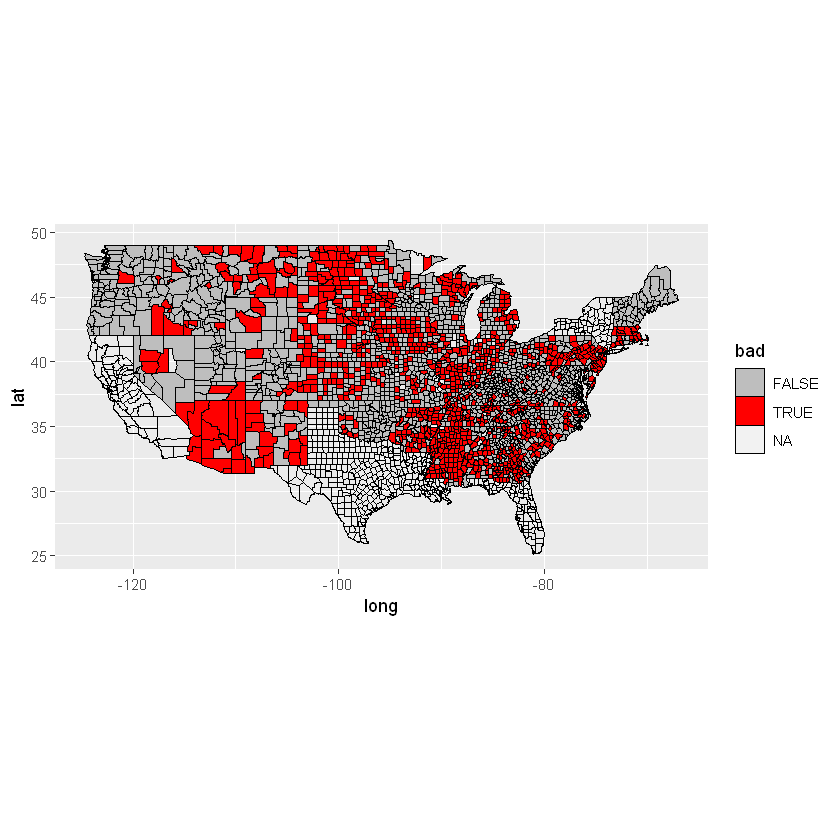

In [29]:
ggplot(counties_test, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = bad), color = "black", size = 0.1) + 
  coord_quickmap() + 
  scale_fill_manual(values = c('TRUE' = 'red', 'FALSE' = 'grey'))

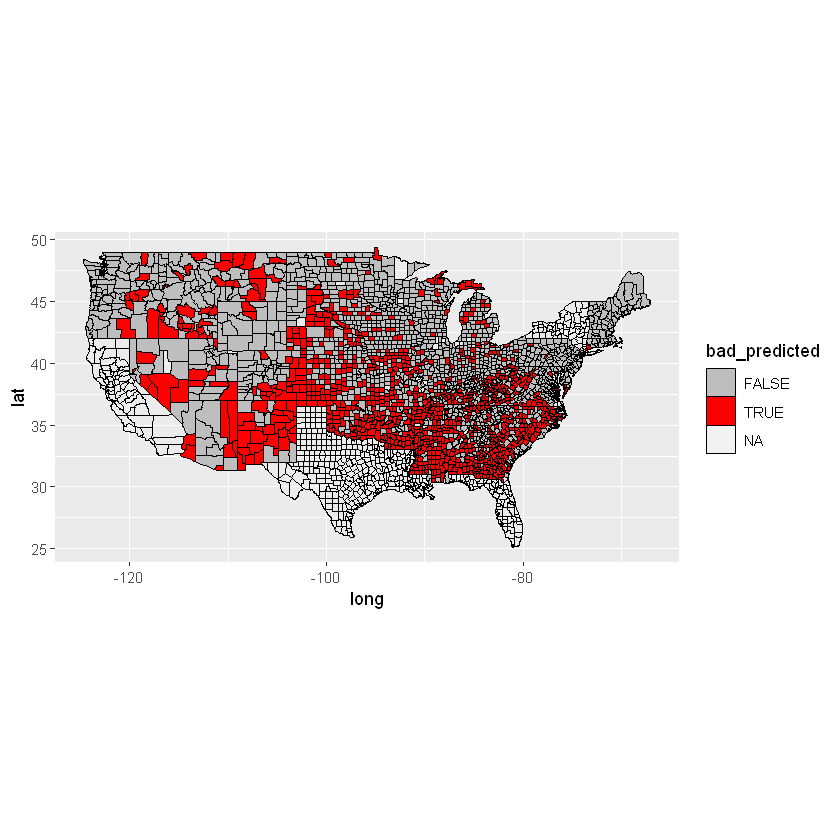

In [30]:
ggplot(counties_test, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = bad_predicted), color = "black", size = 0.1) + 
    coord_quickmap() + 
  scale_fill_manual(values = c('TRUE' = 'red', 'FALSE' = 'grey'))

In [31]:
confusionMatrix(data = cases_test$bad_predicted, ref = cases_test$bad)

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE  1048  526
     TRUE    536  586
                                          
               Accuracy : 0.6061          
                 95% CI : (0.5873, 0.6246)
    No Information Rate : 0.5875          
    P-Value [Acc > NIR] : 0.0262          
                                          
                  Kappa : 0.1883          
                                          
 Mcnemar's Test P-Value : 0.7824          
                                          
            Sensitivity : 0.6616          
            Specificity : 0.5270          
         Pos Pred Value : 0.6658          
         Neg Pred Value : 0.5223          
             Prevalence : 0.5875          
         Detection Rate : 0.3887          
   Detection Prevalence : 0.5838          
      Balanced Accuracy : 0.5943          
                                          
       'Positive' Class : FALSE           
                     